# Visualization with torchboard and matplotlib

## Imports

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

## Transforms 

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((.5,), (.5,))
    ]
)

## Datasets

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    './data', download=True, train=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(
    './data', download=True, train=False, transform=transform)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Dataloaders

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=4, shuffle=True, num_workers=2)

## Classes

In [7]:
classes = 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'

## Define the net

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)    
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
net = Net()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.001, momentum=.9)

## Tensorboard

In [13]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    
    img = img / 2 + .5
    npimg = img.numpy()

    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [21]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

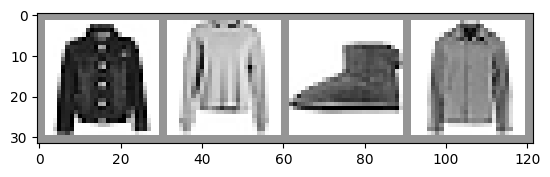

In [15]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

writer.add_image('four_fashion_mnist_images', img_grid)

In [16]:
writer.add_graph(net, images)
writer.close()

Adding a projector

In [22]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

In [27]:
images, labels = select_n_random(train_set.data, train_set.targets)

class_labels = [classes[i] for i in labels]

features = images.view(-1, 28 * 28)

writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

Tracking model training

In [28]:
def images_to_probs(net, images):
    output = net(images)

    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [29]:
def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)

    fig = plt.figure(figsize=(12, 48))

    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
            color=("green" if preds[idx] == labels[idx].item() else "red"))
        
    return fig

In [32]:
running_loss = .0

for epoch in range(1):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 1000 == 999:
            writer.add_scalar('training loss', running_loss /
                              1000, epoch * len(train_loader) + i)
            writer.add_figure('predictions vs actuals', plot_classes_preds(
                net, inputs, labels), global_step=epoch * len(train_loader) + i)
            running_loss = .0

Assesing trained model

In [33]:
class_probs = []
class_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in outputs]

        class_probs.append(class_probs_batch)
        class_labels.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_labels = torch.cat(class_labels)

In [34]:
def add_pr_curve_tensorboard(class_index, test_probs, test_labels, global_step=0):
    tensorboard_truth = test_labels == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index], tensorboard_truth, tensorboard_probs, global_step==global_step)
    writer.close()

In [35]:
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_labels)